In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import statsmodels.api as sm
from scipy import stats
import seaborn as sns
from statsmodels.stats.proportion import proportions_ztest
import os
import matplotlib

from scipy.stats import ttest_rel
from scipy.stats import ttest_ind
from statsmodels.stats.anova import anova_lm
from scipy.stats import shapiro
from statsmodels.formula.api import ols
import statsmodels.formula.api as smf
import statsmodels.api as sm

%matplotlib inline
sns.set(font="AppleGothic")
plt.rcParams['axes.unicode_minus']=False

# 1. [실습] 2-sample t-test 평균검정


In [27]:
thick = [1.435, 1.572, 1.486, 1.883, 1.715, 1.799, 1.511, 1.457, 1.548, 1.768, 1.711, 1.832, 1.427, 1.344, 1.404, 1.883]
supplier = ['B', 'B', 'B', 'A', 'A', 'A','B', 'B', 'B', 'A', 'A', 'A', 'A', 'A', 'B', 'B']
df = pd.DataFrame({'thickness': thick, 'supplier':supplier})
df.head()

,thickness,supplier
0,1.435,B
1,1.572,B
2,1.486,B
3,1.883,A
4,1.715,A


## 1-0. 공급자 범주에 따른 thickness를 정리한 새로운 dataframe생성

In [32]:
sup_a = list(df.loc[(df['supplier']=='A')]['thickness'])
sup_b = list(df.loc[(df['supplier']=='B')]['thickness'])
df_new = pd.DataFrame({'sup_a': sup_a, 'sup_b':sup_b})
df_new

,sup_a,sup_b
0,1.883,1.435
1,1.715,1.572
2,1.799,1.486
3,1.768,1.511
4,1.711,1.457
5,1.832,1.548
6,1.427,1.404
7,1.344,1.883


## 1-1. 통계분석 전에 그래프를 그려 확인
### 목적> 1. 이상치 2. 경향 확인
### 해석> 
공급자 A와 공급자 B의 표본평균에 차이가 있어보인다. 

하지만 모평균의 차이가 존재하는지 정확한 확인을 위해 t-test평균검정이 필요하다.

공급자 B에 이상치일 가능성이 있는 데이터가 있다.

<AxesSubplot:>

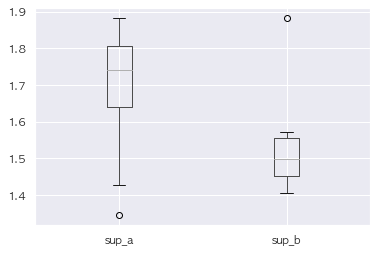

In [34]:
df_new.boxplot(['sup_a','sup_b'])

## 1-2. 정규성 확인
### 해석
sup_a가 공급한 제품 두께의 p-value가 0.08로 0.05보다 크므로 정규성을 만족한다.

sup_b가 공급한 제품 두께의 p-value가 0.014로 0.05보다 작으므로 정규성을 만족하지 않는다.

In [35]:
stats, p = stats.shapiro(df_new['sup_a'])
print("{}의 Shapiro-wilk test: statistic={}, p-value={}".format('sup_a',stats, p))

sup_a의 Shapiro-wilk test: statistic=0.8425756096839905, p-value=0.08004552870988846


In [38]:
stats, p = stats.shapiro(df_new['sup_b'])
print("{}의 Shapiro-wilk test: statistic={}, p-value={}".format('sup_b',stats, p))

sup_b의 Shapiro-wilk test: statistic=0.7734811902046204, p-value=0.014793740585446358


## 1-3. 등분산성 검정: Levene's test (정규분포를 따르지 않을 때)
### 해석
Levene's test결과 p-value이 0.51으로 두 집단의 분산이 동일하다.

In [45]:
print(stats.levene(df_new['sup_a'], df_new['sup_b']))

LeveneResult(statistic=0.4408416728536036, pvalue=0.5175025061092301)


## 1-4. 평균검정
문제> 정규성을 만족하지 않고, 등분산성을 만족하는 상황에서 어떤 t-test를 해야할까?

1. (교재 118page)에 따르면 정규성을 만족하지 않으므로 **mann-whitney 검정**을 실시해야한다.
    - **mann-whitney 검정**=> p-value=0.12이므로 두 집단의 평균은 **같지 않다**.


2. 추가 실험으로 **독립적 2 sample t-test** 실시해보았다.
    - **독립적 2 sample t-test**=>p-value=0.111으로 두 집단의 평균은 같지 않다는 결과가 나왔다.

In [46]:
# mann-whitney 검정
from scipy.stats import mannwhitneyu
print(mannwhitneyu(df_new['sup_a'], df_new['sup_b']))

MannwhitneyuResult(statistic=20.5, pvalue=0.12382392305144829)


In [76]:
# 독립적 2 sample t-test 
t_result = stats.ttest_ind(df_new['sup_a'], df_new['sup_b'], equal_var = True)
t, p = t_result.statistic.round(3), t_result.pvalue.round(3)
print('독립적 2 sample t-test')
print('t 검정 통계량: {}'.format(t))
print('p-value: {}'.format(p))

독립적 2 sample t-test
t 검정 통계량: 1.7
p-value: 0.111


# 2. [실습] paired t-test
### 해석
유의수준 5%에서 검정결과 P값이 0.05이므로 학원 수강 전후 점수 차이가 있다고 할 수 있다.

In [53]:
before = [720, 589, 780, 648, 720, 589, 780, 648, 780, 648]
after = [710, 580, 787, 712, 750, 600, 782, 670, 790, 680]
df = pd.DataFrame({'before': before, 'after':after})
df1 = df['before']
df2 = df['after']
t_result = ttest_rel(df1, df2)
t,p = t_result.statistic.round(3),  t_result.pvalue.round(3)
print('t 검정통계량: {}'.format(t))
print('p-value: {}'.format(p))

t 검정통계량: -2.266
p-value: 0.05


# 3. [실습] 1 proportion test
### 해석
유의수준 5%에서 검정결과 P값이 0.041이므로 정상적인 동전이 가지는 앞면 비율과 차이가 있다.

In [28]:
from statsmodels.stats.proportion import proportions_ztest

In [61]:
value = 0.5
count = 40
n_obs = 100 # 앞면 횟수

stat, p = proportions_ztest(count, n_obs, value)

print('z: {0:0.3f}'.format(stat))
print('p-value: {0:0.3f}'.format(p))

z: -2.041
p-value: 0.041


# 4. [실습] 2 proportion test
### 해석
유의수준 5%에서 검정결과 P값이 0.038이므로 두 공정의 불량률 같지 않다.

In [60]:

count = np.array([14,5])
n_obs = np.array([1200, 1200])

stat, p = proportions_ztest(count, n_obs)
print('z: {0:0.3f}'.format(stat))
print('p: {0:0.3f}'.format(p))

z: 2.073
p: 0.038


# 5. [실습] 카이제곱 검정 
### 해석
카이제곱 값이 95.76으로 매우 크며, p-value가 0.0000000086으로 거의 0에 가깝다.

=>따라서 유의수준 5%에서 각 제품별로 이미지에 차이가 있다고 할 수 있다.

In [62]:
dir_ = '/Users/dasol/Documents/GitHub/Big-Data-Analysis/POSCO_classnote'
df = pd.read_csv(dir_+'/통계data/카이제곱_노트북.csv', engine="python")
df

,A,B,C,D,E,F
0,18,8,4,4,3,3
1,2,2,1,1,1,25
2,14,14,3,2,3,8
3,5,5,4,3,1,10
4,5,5,9,2,1,2
5,9,9,5,7,1,1
6,4,4,4,3,1,7


In [66]:
# chi-square test 실행
# 차이가 있다.
from scipy.stats import chi2_contingency

chi, pval, dof, expected = stats.chi2_contingency(df)

print('chi-square test')
print('chisq: {:0.2f}'.format(chi))
print('p: {:0.10f}'.format(pval))
print('degree pf freedom: {}'.format(dof))
print('expected value: \n{}'.format(expected.round(1)))

chi-square test
chisq: 95.76
p: 0.0000000086
degree pf freedom: 30
expected value: 
[[10.2  8.4  5.4  3.9  2.  10. ]
 [ 8.2  6.7  4.3  3.2  1.6  8. ]
 [11.2  9.3  5.9  4.3  2.2 11. ]
 [ 7.2  5.9  3.8  2.8  1.4  7. ]
 [ 6.1  5.1  3.2  2.4  1.2  6. ]
 [ 8.2  6.7  4.3  3.2  1.6  8. ]
 [ 5.9  4.8  3.1  2.3  1.1  5.8]]


# 6. [실습] One-way ANOVA

### 6-1. y는 연속형, x인 gangjong과 type은 범주형이므로 ANOVA분석을 실행한다.

In [69]:
df = pd.read_csv(dir_+'/1 통계이해/ANOVA.csv', engine="python")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   time      24 non-null     float64
 1   charge    24 non-null     object 
 2   gangjong  24 non-null     object 
 3   type      24 non-null     object 
dtypes: float64(1), object(3)
memory usage: 896.0+ bytes


In [71]:
df.head()

,time,charge,gangjong,type
0,32.2,A,a,a
1,30.4,B,a,a
2,33.6,C,a,a
3,36.4,D,a,a
4,33.9,E,a,a


### 6-2. 강종 종류에 따른 박스 plot으로 시각화
해석: 강종은 4가지 그룹으로 나뉘어져 있으며, 특히 강종 a와 강종 d의 2차정련시간 차이가 가장 커보인다.

     반면 type은 두 범주(a와 b) 밖에 없어서 집단간 차이가 상대적으로 작게 측정될 것으로 예상해보았다.

<AxesSubplot:title={'center':'time'}, xlabel='gangjong'>

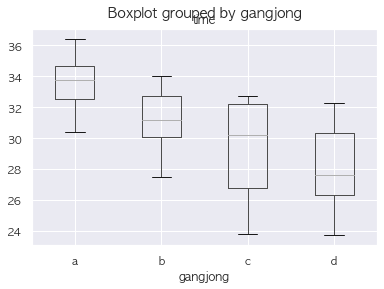

In [70]:
df.boxplot(column='time', by='gangjong') # by: 범주별로 시간 보여준다

<AxesSubplot:title={'center':'time'}, xlabel='type'>

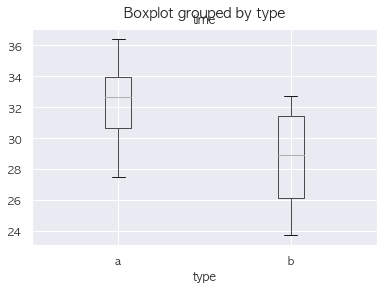

In [73]:
df.boxplot(column='time', by='type') 

### 6-3. ordinary linear square 적합
OLS 적합 이유> x가 범주형 y가 연속형인 데이터를 선형회귀모델에 적합시켜 **총 변동에 대한 오차에 의한 변동의 비율을 계산하기 위해서**.

해석1 : 유의수준 5%에서 강종의 p-value가 0.019이므로 강종별 2차정련시간이 같지 않다.

해석2 : 유의수준 5%에서 type의 p-value가 0.005이므로 type별 2차정련시간이 같지 않다.

In [75]:
# OLS=>Create a Model from a formula and dataframe.
lm = ols('time ~ C(gangjong)', data=df).fit() # linear_model
print(anova_lm(lm))

               df      sum_sq    mean_sq         F    PR(>F)
C(gangjong)   3.0  104.603333  34.867778  4.171868  0.019013
Residual     20.0  167.156667   8.357833       NaN       NaN


In [80]:
lm = ols('time ~ C(type)', data=df).fit() 
print(anova_lm(lm))

            df      sum_sq    mean_sq         F   PR(>F)
C(type)    1.0   82.881667  82.881667  9.653816  0.00514
Residual  22.0  188.878333   8.585379       NaN      NaN
